# SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import warnings
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors

import json

from tqdm import tqdm
from typing import Any, Dict, Tuple, List, Optional
from collections import Counter

import tensorflow as tf
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)

import datetime

plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 12,
    "font.family": "sans-serif",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    #"axes.spines.top": False,
    #"axes.spines.right": False,
    "legend.frameon": False
    #"axes.grid" : True,
    #"grid.color": "gray",
    #"grid.linestyle": "--",
    #"grid.linewidth": 0.5,
    #"grid.alpha": 0.3,
})

In [ ]:
TELESCOPE = {
    "LUVOIR": dict(prefix="B",
                   region_bins={"UV": 8,  "Vis": 94,  "NIR": 49}),
    "HABEX" : dict(prefix="SS",
                   region_bins={"UV": 7,  "Vis":109,  "NIR": 25}),
}

In [ ]:
def parse_example(example_proto: tf.Tensor,
                  input_stats: Dict[str, Tuple[float, float]],
                  output_stats: Dict[str, Any],
                  telescope: str = "LUVOIR"):

    meta   = TELESCOPE[telescope]
    pfx    = meta["prefix"]
    bins   = meta["region_bins"]

    # 1) Define raw feature schemas.
    raw_input_features = {f'NOISY_ALBEDO_{pfx}-{r}': tf.io.VarLenFeature(tf.float32)
              for r in ['NIR','UV','Vis']}

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        'Earth_type': tf.io.FixedLenFeature([], tf.string),
        'OBJECT-STAR-TYPE': tf.io.FixedLenFeature([], tf.string),
        'GEOMETRY-OBS-ALTITUDE': tf.io.FixedLenFeature([], tf.float32),
    }

    clean_albedo_features = {f'ALBEDO_{pfx}-{r}': tf.io.VarLenFeature(tf.float32)
                         for r in ['NIR', 'UV', 'Vis']}

    # 2) Parse the example.
    all_features = {**raw_input_features, **clean_albedo_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_{pfx}-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        normalized   = tf.reshape(normalized, [bins[region], 1])
        normalized_inputs[f'NOISY_ALBEDO_{pfx}-{region}'] = normalized

    # Just to visualize in the same units
    clean_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum_clean = parsed[f'ALBEDO_{pfx}-{region}']
        if isinstance(spectrum_clean, tf.SparseTensor):
            spectrum_clean = tf.sparse.to_dense(spectrum_clean, default_value=0.0)

        # mean = input_stats[region][0]
        # std  = input_stats[region][1]
        # normalized = (spectrum_clean - mean) / std

        spectrum_clean   = tf.reshape(spectrum_clean, [bins[region], 1])
        clean_inputs[f'ALBEDO_{pfx}-{region}'] = spectrum_clean

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO2', 'H2O', 'N2']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,
        'main_chemical_output': main_chemical_outputs,
        'other_chemical_output': other_chemical_outputs,
        'earth_type': parsed['Earth_type'],
        'star_type': parsed['OBJECT-STAR-TYPE'],
        'obs_altitude': parsed['GEOMETRY-OBS-ALTITUDE'],
    }

    return normalized_inputs, grouped_outputs, clean_inputs


def read_tfrecord(file_path: str,
                  telescope: str = "LUVOIR",
                  batch_size: int = 1024,
                  shuffle_buffer: Optional[int] = None,
                  repeat: bool = False):

    meta  = TELESCOPE[telescope]
    pfx   = meta["prefix"]

    with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {r: (stats['inputs'][f'{pfx}-{r}']['mean'],
                       stats['inputs'][f'{pfx}-{r}']['std'])
                   for r in ['UV','Vis','NIR']}

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats, telescope=telescope),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

In [ ]:
luvoir_ds  = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/samples.tfrecord", telescope="LUVOIR", batch_size=1)
habex_ds  = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/samples.tfrecord", telescope="HABEX", batch_size=1)

In [ ]:
model_LUVOIR = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/LUVOIR_NEW.keras")
model_HABEX = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/HABEX_NEW.keras")

In [ ]:
model_LUVOIR.summary()

Model: "Net22_hyper"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_B-UV   │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-Vis  │ (None, 94, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-NIR  │ (None, 49, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 151, 1)    │          0 │ NOISY_ALBEDO_B-U… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_B-V… │
│                     │                   │            │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 151, 56)   │      2,856 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 151, 56)   │        224 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 151, 56)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_4 │ (None, 151, 56)   │          0 │ activation_4[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 151, 56)   │    156,856 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 151, 56)   │        224 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 151, 56)   │          0 │ concatenate_1[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 151, 56)   │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 151, 56)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_5 │ (None, 151, 56)   │          0 │ max_pooling1d_2[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 76, 56)    │    156,856 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 76, 56)    │    473,592 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 76, 56)    │        224 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 76, 56)    │          0 │ batch_normalizat

 Total params: 5,275,392 (20.12 MB)

 Trainable params: 1,758,314 (6.71 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 3,516,630 (13.41 MB)

In [ ]:
model_HABEX.summary()

Model: "Net22_hyper"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_SS-UV  │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_SS-Vis │ (None, 109, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_SS-NIR │ (None, 25, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 141, 1)    │          0 │ NOISY_ALBEDO_SS-… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_SS-… │
│                     │                   │            │ NOISY_ALBEDO_SS-… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 141, 56)   │      2,016 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 141, 56)   │        224 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 141, 56)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_4 │ (None, 141, 56)   │          0 │ activation_4[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 141, 56)   │    109,816 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 141, 56)   │        224 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 141, 56)   │          0 │ concatenate_1[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 141, 56)   │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 141, 56)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_5 │ (None, 141, 56)   │          0 │ max_pooling1d_2[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 71, 56)    │    109,816 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 71, 56)    │    442,232 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 56)    │        224 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 71, 56)    │          0 │ batch_normalizat

 Total params: 4,718,976 (18.00 MB)

 Trainable params: 1,572,842 (6.00 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 3,145,686 (12.00 MB)

# INTEGRATED GRADIENTS

https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=pt-br

In [ ]:
def integrated_gradients(model, input_dict, baseline_dict, target_group='main_chemical_output', target_index=1, steps=50):
    # Create a vector of interpolation coefficients alpha in (0, 1]
    alphas = np.linspace(1.0 / steps, 1.0, steps)

    # Store per-step gradients for every input tensor
    grads = []

    # Loop over interpolation points
    for alpha in alphas:
        # Build the interpolated sample
        interpolated_input = {
            key: tf.convert_to_tensor((1 - alpha) * baseline_dict[key] + alpha * input_dict[key],
                                      dtype=tf.float32)
            for key in input_dict                          # loop over every feature group
        }

        # Record gradients
        with tf.GradientTape() as tape:
            for tensor in interpolated_input.values():
                tape.watch(tensor)

            # Forward pass: model returns a dict of outputs
            preds = model(interpolated_input)

            # Select the scalar of interest (batch dim kept)
            output = preds[target_group][:, target_index]

        # Backward pass: nabla output / nabla (interpolated_input)
        grad = tape.gradient(output, interpolated_input)

        # Save numpy copy of gradients for the first (only) batch element
        grads.append({k: grad[k].numpy()[0] for k in grad})

    # Average gradients across the alpha-path
    avg_grads = {
        k: np.mean(np.array([step[k] for step in grads]), axis=0)  # ⟨gradF⟩
        for k in grads[0]
    }

    # Compute integrated gradients
    ig_dict = {
        k: (input_dict[k].numpy()[0] - baseline_dict[k].numpy()[0]) * avg_grads[k]
        for k in input_dict
    }

    return ig_dict

In [ ]:
uv_b = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
vis_b = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
nir_b = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

uv_ss = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745])
vis_ss = np.array([0.45      , 0.45321429, 0.45645153, 0.4597119 , 0.46299556,
       0.46630267, 0.4696334 , 0.47298792, 0.47636641, 0.47976903,
       0.48319595, 0.48664735, 0.4901234 , 0.49362428, 0.49715017,
       0.50070124, 0.50427768, 0.50787966, 0.51150737, 0.515161  ,
       0.51884072, 0.52254673, 0.5262792 , 0.53003834, 0.53382433,
       0.53763736, 0.54147762, 0.54534532, 0.54924065, 0.55316379,
       0.55711496, 0.56109436, 0.56510217, 0.56913862, 0.57320389,
       0.57729821, 0.58142176, 0.58557478, 0.58975745, 0.59397001,
       0.59821265, 0.6024856 , 0.60678907, 0.61112327, 0.61548844,
       0.61988479, 0.62431253, 0.62877191, 0.63326314, 0.63778645,
       0.64234206, 0.64693022, 0.65155115, 0.65620509, 0.66089227,
       0.66561293, 0.6703673 , 0.67515564, 0.67997818, 0.68483517,
       0.68972685, 0.69465347, 0.69961528, 0.70461253, 0.70964548,
       0.71471438, 0.71981948, 0.72496105, 0.73013934, 0.73535462,
       0.74060715, 0.7458972 , 0.75122504, 0.75659093, 0.76199516,
       0.76743798, 0.77291968, 0.77844053, 0.78400082, 0.78960083,
       0.79524083, 0.80092113, 0.80664199, 0.81240372, 0.8182066 ,
       0.82405094, 0.82993701, 0.83586514, 0.8418356 , 0.84784871,
       0.85390477, 0.86000409, 0.86614698, 0.87233374, 0.8785647 ,
       0.88484016, 0.89116045, 0.89752588, 0.90393678, 0.91039347,
       0.91689628, 0.92344554, 0.93004158, 0.93668473, 0.94337534,
       0.95011373, 0.95690026, 0.96373526, 0.97061909])
nir_ss = np.array([0.975     , 0.999375  , 1.02435937, 1.04996836, 1.07621757,
       1.10312301, 1.13070108, 1.15896861, 1.18794282, 1.2176414 ,
       1.24808243, 1.27928449, 1.3112666 , 1.34404827, 1.37764947,
       1.41209071, 1.44739298, 1.4835778 , 1.52066725, 1.55868393,
       1.59765103, 1.63759231, 1.67853211, 1.72049542, 1.7635078 ])

In [ ]:
def group_by_era(ds):
    buckets = {}
    for sample in ds:                                   # sample = (inputs, outputs, clean)
        era = sample[1]['earth_type'][0].numpy().decode().lower()
        buckets.setdefault(era, []).append(sample)
    return buckets

def ig_curve(model, inp, base, group, idx, bands):
    ig = integrated_gradients(model, inp, base, group, idx)
    return np.concatenate([ig[b].squeeze() for b in bands])

In [ ]:
gas_targets = {
    'O2' : ('main_chemical_output', 0),
    'O3' : ('main_chemical_output', 1),
    'CH4': ('other_chemical_output', 0),
    'CO2': ('other_chemical_output', 1),
    'H2O': ('other_chemical_output', 2),
    'N2' : ('other_chemical_output', 3),
}

colors = {'O2':'k','O3':'tab:gray','CH4':'tab:orange',
          'CO2':'tab:red','H2O':'tab:green','N2':'tab:pink'}

bands_B  = ['NOISY_ALBEDO_B-UV','NOISY_ALBEDO_B-Vis','NOISY_ALBEDO_B-NIR']
bands_SS = ['NOISY_ALBEDO_SS-UV','NOISY_ALBEDO_SS-Vis','NOISY_ALBEDO_SS-NIR']
wave_B   = np.concatenate([uv_b,  vis_b,  nir_b ])
wave_SS  = np.concatenate([uv_ss, vis_ss, nir_ss])

In [ ]:
b_L = group_by_era(luvoir_ds)
b_H = group_by_era(habex_ds)

eras = ['modern', 'proterozoic', 'archean']
rng  = random.Random(0)

pairs = {}
for era in eras:
    n = min(len(b_L[era]), len(b_H[era]))
    idx = rng.randrange(n)
    pairs[era] = (b_L[era][idx], b_H[era][idx])

In [ ]:
baseline_B  = {k: tf.zeros_like(v) for k,v in pairs['modern'][0][0].items()}
baseline_SS = {k: tf.zeros_like(v) for k,v in pairs['modern'][1][0].items()}

In [ ]:
ig_L, ig_H = {}, {}
for era in eras:
    inpL, _, _ = pairs[era][0]
    inpH, _, _ = pairs[era][1]
    ig_L[era] = {gas: ig_curve(model_LUVOIR, inpL, baseline_B,
                               grp, idx, bands_B)
                 for gas,(grp,idx) in gas_targets.items()}
    ig_H[era] = {gas: ig_curve(model_HABEX, inpH, baseline_SS,
                               grp, idx, bands_SS)
                 for gas,(grp,idx) in gas_targets.items()}

In [ ]:
with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
  stats = json.load(f)

In [ ]:
best_n_O2 = stats["outputs"]['O2']['best_n']
best_n_O3 = stats["outputs"]['O3']['best_n']

mean_b = {'UV': stats['inputs']['B-UV']['mean'],
          'Vis': stats['inputs']['B-Vis']['mean'],
          'NIR': stats['inputs']['B-NIR']['mean']}
std_b  = {'UV': stats['inputs']['B-UV']['std'],
          'Vis': stats['inputs']['B-Vis']['std'],
          'NIR': stats['inputs']['B-NIR']['std']}

mean_ss = {'UV': stats['inputs']['SS-UV']['mean'],
           'Vis': stats['inputs']['SS-Vis']['mean'],
           'NIR': stats['inputs']['SS-NIR']['mean']}
std_ss  = {'UV': stats['inputs']['SS-UV']['std'],
           'Vis': stats['inputs']['SS-Vis']['std'],
           'NIR': stats['inputs']['SS-NIR']['std']}

def denorm_albedo(inputs_dict, clean_dict, mean, std, prefix):
    """prefix = 'B-'  ou 'SS-'  (inclui o hífen)"""

    uv_noisy  = inputs_dict[f'NOISY_ALBEDO_{prefix}UV' ][0].numpy().squeeze()
    vis_noisy = inputs_dict[f'NOISY_ALBEDO_{prefix}Vis'][0].numpy().squeeze()
    nir_noisy = inputs_dict[f'NOISY_ALBEDO_{prefix}NIR'][0].numpy().squeeze()

    uv_clean  = clean_dict[f'ALBEDO_{prefix}UV' ][0].numpy().squeeze()
    vis_clean = clean_dict[f'ALBEDO_{prefix}Vis'][0].numpy().squeeze()
    nir_clean = clean_dict[f'ALBEDO_{prefix}NIR'][0].numpy().squeeze()

    uv_noisy  = uv_noisy  * std['UV']  + mean['UV']
    vis_noisy = vis_noisy * std['Vis'] + mean['Vis']
    nir_noisy = nir_noisy * std['NIR'] + mean['NIR']

    noisy_vec = np.concatenate([uv_noisy, vis_noisy, nir_noisy])
    clean_vec = np.concatenate([uv_clean, vis_clean, nir_clean])
    return noisy_vec, clean_vec

In [ ]:
gas_palette = {
    'O2': 'tab:red',
    'O3': 'tab:blue',
}

soft_colors = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown']

front = ['O2', 'O3']
back  = [g for g in gas_targets if g not in front]

for g, c in zip(back, soft_colors):
    gas_palette[g] = c

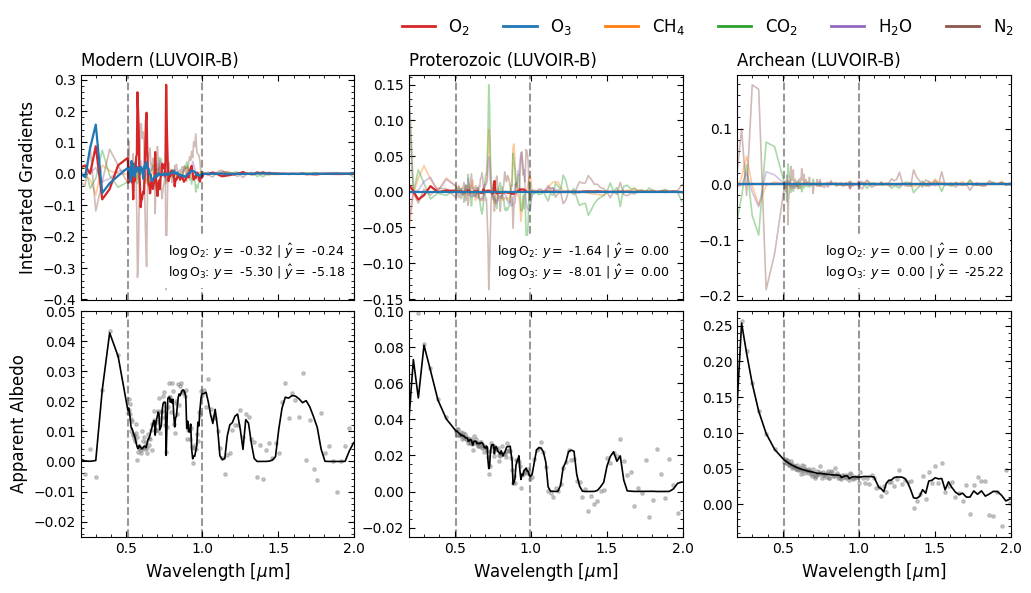

In [ ]:
figL, axL = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

for j, era in enumerate(eras):
    for g in back:
        axL[0,j].plot(wave_B, ig_L[era][g],
                      color=gas_palette[g], lw=1.2, alpha=0.4)
    for g in front:
        axL[0,j].plot(wave_B, ig_L[era][g],
                      color=gas_palette[g], lw=1.6)
    axL[0,j].set_title(f"{era.capitalize()} (LUVOIR-B)", loc="left")

    inp, _, clean = pairs[era][0]
    noisy, clean_vec = denorm_albedo(inp, clean, mean_b, std_b, prefix='B-')
    axL[1,j].scatter(wave_B, noisy,  color='tab:gray', s=6, alpha=0.4)
    axL[1,j].plot(wave_B, clean_vec, color='k', lw=1.2)
    axL[1,0].set_ylim(-0.025, 0.05)
    axL[1,1].set_ylim(-0.025, 0.1)

    uv_end_B  = uv_b [-1]
    vis_end_B = vis_b[-1]

    axL[0, j].axvline(uv_end_B,  ls='--', c='k', alpha=0.4)
    axL[0, j].axvline(vis_end_B, ls='--', c='k', alpha=0.4)
    axL[1, j].axvline(uv_end_B,  ls='--', c='k', alpha=0.4)
    axL[1, j].axvline(vis_end_B, ls='--', c='k', alpha=0.4)

    for i in (0,1):
        axL[i,j].set_xlim(0.2,2)

    inp_L, out_L, _ = pairs[era][0]
    pred_L = model_LUVOIR(inp_L, training=True)

    true_O2_L = out_L['main_chemical_output'][0, 0].numpy() ** best_n_O2
    pred_O2_L = pred_L['main_chemical_output'][0, 0].numpy() ** best_n_O2
    true_O3_L = out_L['main_chemical_output'][0, 1].numpy() ** best_n_O3
    pred_O3_L = pred_L['main_chemical_output'][0, 1].numpy() ** best_n_O3

    def log_or_zero(x):
        return 0.0 if x <= 0 else np.log10(x)

    fmt = lambda v: f"{log_or_zero(v):.2f}"

    axL[0, j].text(
        0.32, 0.1,
        rf"$\log\mathrm{{O_2}}$: $y =$ {fmt(true_O2_L)} | $\hat y =$ {fmt(pred_O2_L)}" + "\n" +
        rf"$\log\mathrm{{O_3}}$: $y =$ {fmt(true_O3_L)} | $\hat y =$ {fmt(pred_O3_L)}",
        transform=axL[0, j].transAxes,
        fontsize= 9,
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
    )

axL[0,0].set_ylabel("Integrated Gradients")
axL[1,0].set_ylabel("Apparent Albedo")
for j in range(3):
    axL[1,j].set_xlabel("Wavelength [$\\mu$m]")

pretty = {'O2': r'$\mathrm{O_2}$',
          'O3': r'$\mathrm{O_3}$',
          'CH4': r'$\mathrm{CH_4}$',
          'CO': r'$\mathrm{CO}$',
          'CO2': r'$\mathrm{CO_2}$',
          'H2O': r'$\mathrm{H_2O}$',
          'N2': r'$\mathrm{N_2}$',
          'N2O': r'$\mathrm{N_2O}$'}

order   = front + back
handles = [plt.Line2D([], [], color=gas_palette[g], lw=2) for g in order]
labels  = [pretty[g] for g in order]
figL.legend(handles, labels,
            loc='center left',
            bbox_to_anchor=(0.38, .96),
            frameon=False,
            ncol=6)
plt.subplots_adjust(wspace=0.2, hspace=0.05)
# plt.savefig("integrated_gradients_luvoir.pdf", bbox_inches='tight')
plt.show()

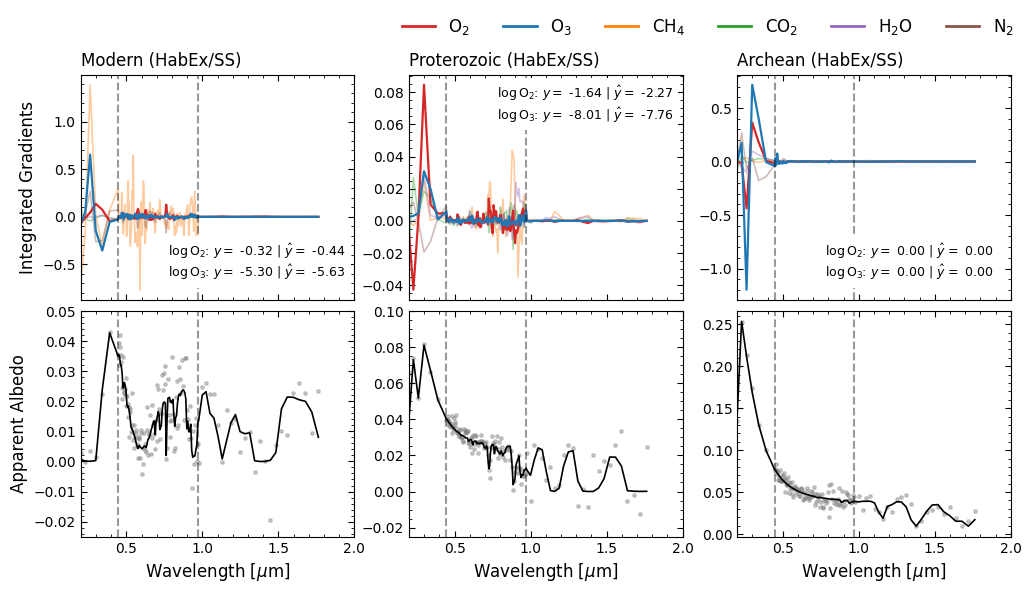

In [ ]:
figH, axH = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

for j, era in enumerate(eras):
    for g in back:
        axH[0,j].plot(wave_SS, ig_H[era][g],
                      color=gas_palette[g], lw=1.2, alpha=0.4)
    for g in front:
        axH[0,j].plot(wave_SS, ig_H[era][g],
                      color=gas_palette[g], lw=1.6)
    axH[0,j].set_title(f"{era.capitalize()} (HabEx/SS)", loc="left")

    inp, _, clean = pairs[era][1]
    noisy, clean_vec = denorm_albedo(inp, clean, mean_ss, std_ss, prefix='SS-')
    axH[1,j].scatter(wave_SS, noisy,  color='tab:gray', s=6, alpha=0.4)
    axH[1,j].plot(wave_SS, clean_vec, color='k', lw=1.2)
    axH[1,0].set_ylim(-0.025, 0.05)
    axH[1,1].set_ylim(-0.025, 0.1)

    uv_end_SS  = uv_ss[-1]
    vis_end_SS = vis_ss[-1]

    axH[0, j].axvline(uv_end_SS,  ls='--', c='k', alpha=0.4)
    axH[0, j].axvline(vis_end_SS, ls='--', c='k', alpha=0.4)
    axH[1, j].axvline(uv_end_SS,  ls='--', c='k', alpha=0.4)
    axH[1, j].axvline(vis_end_SS, ls='--', c='k', alpha=0.4)

    for i in (0,1):
        axH[i,j].set_xlim(0.2,2)

    inp_H, out_H, _ = pairs[era][1]
    pred_H = model_HABEX(inp_H, training=True)

    true_O2_H = out_H['main_chemical_output'][0, 0].numpy() ** best_n_O2
    pred_O2_H = pred_H['main_chemical_output'][0, 0].numpy() ** best_n_O2
    true_O3_H = out_H['main_chemical_output'][0, 1].numpy() ** best_n_O3
    pred_O3_H = pred_H['main_chemical_output'][0, 1].numpy() ** best_n_O3

    def log_or_zero(x):
        return 0.0 if x <= 0 else np.log10(x)

    fmt = lambda v: f"{log_or_zero(v):.2f}"

    if era != "proterozoic":
      axH[0, j].text(
          0.32, 0.1,
          rf"$\log\mathrm{{O_2}}$: $y =$ {fmt(true_O2_H)} | $\hat y =$ {fmt(pred_O2_H)}" + "\n" +
          rf"$\log\mathrm{{O_3}}$: $y =$ {fmt(true_O3_H)} | $\hat y =$ {fmt(pred_O3_H)}",
          transform=axH[0, j].transAxes,
          fontsize= 9,
          bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
      )
    else:
      axH[0, j].text(
          0.32, 0.8,
          rf"$\log\mathrm{{O_2}}$: $y =$ {fmt(true_O2_H)} | $\hat y =$ {fmt(pred_O2_H)}" + "\n" +
          rf"$\log\mathrm{{O_3}}$: $y =$ {fmt(true_O3_H)} | $\hat y =$ {fmt(pred_O3_H)}",
          transform=axH[0, j].transAxes,
          fontsize= 9,
          bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
      )

axH[0,0].set_ylabel("Integrated Gradients")
axH[1,0].set_ylabel("Apparent Albedo")
for j in range(3):
    axH[1,j].set_xlabel("Wavelength [$\\mu$m]")

pretty = {'O2': r'$\mathrm{O_2}$',
          'O3': r'$\mathrm{O_3}$',
          'CH4': r'$\mathrm{CH_4}$',
          'CO': r'$\mathrm{CO}$',
          'CO2': r'$\mathrm{CO_2}$',
          'H2O': r'$\mathrm{H_2O}$',
          'N2': r'$\mathrm{N_2}$',
          'N2O': r'$\mathrm{N_2O}$'}

order   = front + back
handles = [plt.Line2D([], [], color=gas_palette[g], lw=2) for g in order]
labels  = [pretty[g] for g in order]
figH.legend(handles, labels,
            loc='center left',
            bbox_to_anchor=(0.38, .96),
            frameon=False,
            ncol=6)
plt.subplots_adjust(hspace=0.05)
# plt.savefig("integrated_gradients_habex.pdf", bbox_inches='tight')
plt.show()

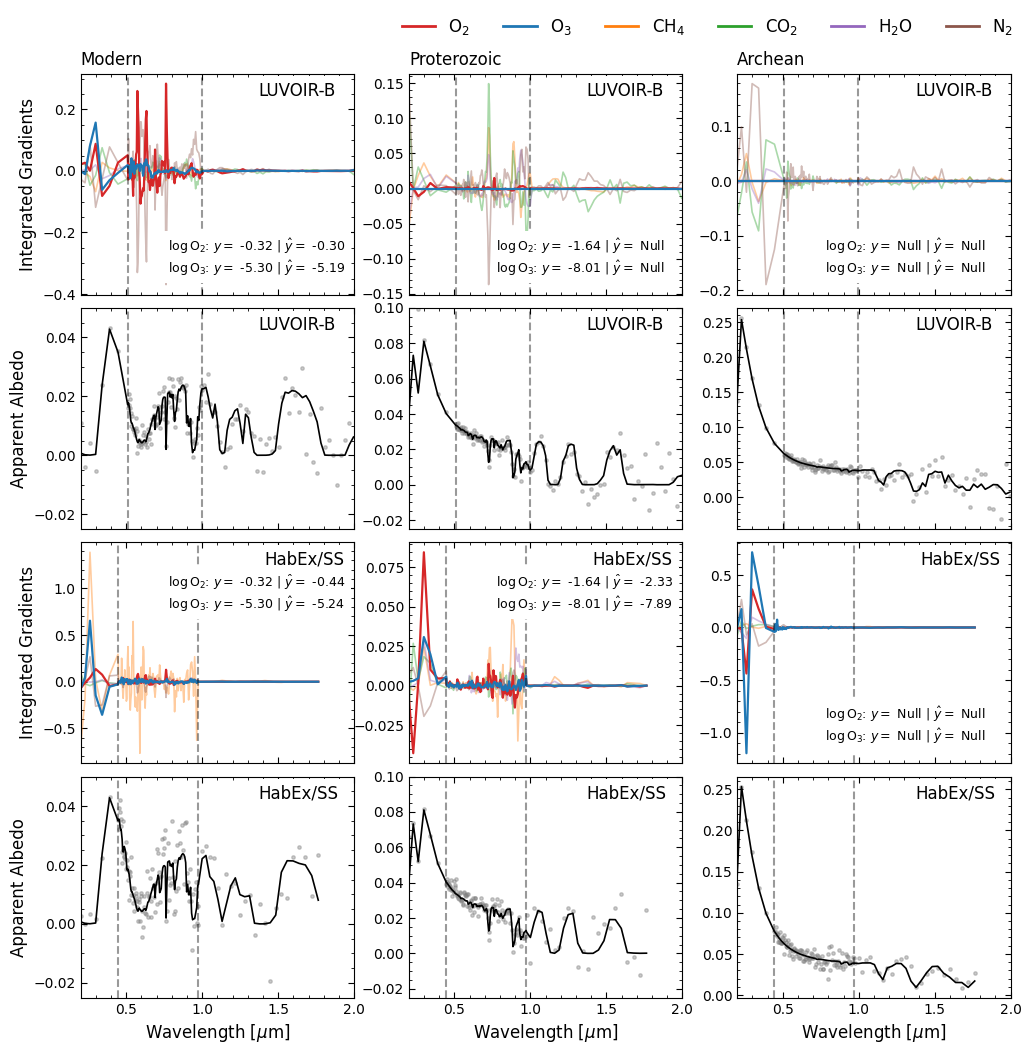

In [ ]:
def fmt_log_or_null(x):
    return "Null" if x <= 0 else f"{np.log10(x):.2f}"

fig, ax = plt.subplots(
    4, 3,
    figsize=(12, 12),
    sharex=True
)
plt.subplots_adjust(wspace=0.20, hspace=0.06)


LUVOIR_ROWS = (0, 1)
HABEX_ROWS  = (2, 3)

# LUVOIR-B
for j, era in enumerate(eras):
    for g in back:
        ax[LUVOIR_ROWS[0], j].plot(wave_B, ig_L[era][g],
                                   color=gas_palette[g], lw=1.2, alpha=0.4)
    for g in front:
        ax[LUVOIR_ROWS[0], j].plot(wave_B, ig_L[era][g],
                                   color=gas_palette[g], lw=1.6)
    ax[LUVOIR_ROWS[0], j].set_title(f"{era.capitalize()}", loc="left")

    inp, _, clean = pairs[era][0]
    noisy, clean_vec = denorm_albedo(inp, clean, mean_b, std_b, prefix='B-')
    ax[LUVOIR_ROWS[1], j].scatter(wave_B, noisy, color='tab:gray', s=6, alpha=0.4)
    ax[LUVOIR_ROWS[1], j].plot(wave_B, clean_vec, color='k', lw=1.2)
    ax[LUVOIR_ROWS[1], 0].set_ylim(-0.025, 0.05)
    ax[LUVOIR_ROWS[1], 1].set_ylim(-0.025, 0.1)

    for r in LUVOIR_ROWS:
        for vline in (uv_b[-1], vis_b[-1]):
            ax[r, j].axvline(vline, ls='--', c='k', alpha=0.4)
        ax[r, j].set_xlim(0.2, 2)

    inp_L, out_L, _ = pairs[era][0]
    pred_L = model_LUVOIR(inp_L, training=True)
    true_O2_L = out_L['main_chemical_output'][0, 0].numpy() ** best_n_O2
    pred_O2_L = pred_L['main_chemical_output'][0, 0].numpy() ** best_n_O2
    true_O3_L = out_L['main_chemical_output'][0, 1].numpy() ** best_n_O3
    pred_O3_L = pred_L['main_chemical_output'][0, 1].numpy() ** best_n_O3

    ax[LUVOIR_ROWS[0], j].text(
        0.32, 0.10,
        rf"$\log\mathrm{{O_2}}$: $y =$ {fmt_log_or_null(true_O2_L)} | "
        rf"$\hat y =$ {fmt_log_or_null(pred_O2_L)}" "\n"
        rf"$\log\mathrm{{O_3}}$: $y =$ {fmt_log_or_null(true_O3_L)} | "
        rf"$\hat y =$ {fmt_log_or_null(pred_O3_L)}",
        transform=ax[LUVOIR_ROWS[0], j].transAxes,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
    )

    for r in LUVOIR_ROWS:
      ax[LUVOIR_ROWS[r], j].text(
          0.65, 0.9, "LUVOIR-B",
          transform=ax[LUVOIR_ROWS[r], j].transAxes,
          fontsize=12,
          bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
      )

# HabEx
for j, era in enumerate(eras):
    ig_row, alb_row = HABEX_ROWS

    for g in back:
        ax[ig_row, j].plot(wave_SS, ig_H[era][g],
                           color=gas_palette[g], lw=1.2, alpha=0.4)
    for g in front:
        ax[ig_row, j].plot(wave_SS, ig_H[era][g],
                           color=gas_palette[g], lw=1.6)
    # ax[ig_row, j].set_title(f"{era.capitalize()}  (HabEx/SS)", loc="left")

    inp, _, clean = pairs[era][1]
    noisy, clean_vec = denorm_albedo(inp, clean, mean_ss, std_ss, prefix='SS-')
    ax[alb_row, j].scatter(wave_SS, noisy, color='tab:gray', s=6, alpha=0.4)
    ax[alb_row, j].plot(wave_SS, clean_vec, color='k', lw=1.2)
    ax[alb_row, 0].set_ylim(-0.025, 0.05)
    ax[alb_row, 1].set_ylim(-0.025, 0.1)

    for r in HABEX_ROWS:
        for vline in (uv_ss[-1], vis_ss[-1]):
            ax[r, j].axvline(vline, ls='--', c='k', alpha=0.4)
        ax[r, j].set_xlim(0.2, 2)

    inp_H, out_H, _ = pairs[era][1]
    pred_H = model_HABEX(inp_H, training=True)
    true_O2_H = out_H['main_chemical_output'][0, 0].numpy() ** best_n_O2
    pred_O2_H = pred_H['main_chemical_output'][0, 0].numpy() ** best_n_O2
    true_O3_H = out_H['main_chemical_output'][0, 1].numpy() ** best_n_O3
    pred_O3_H = pred_H['main_chemical_output'][0, 1].numpy() ** best_n_O3

    y_anchor = 0.7 if era == "modern" or era == "proterozoic" else 0.10
    ax[ig_row, j].text(
        0.32, y_anchor,
        rf"$\log\mathrm{{O_2}}$: $y =$ {fmt_log_or_null(true_O2_H)} | "
        rf"$\hat y =$ {fmt_log_or_null(pred_O2_H)}" "\n"
        rf"$\log\mathrm{{O_3}}$: $y =$ {fmt_log_or_null(true_O3_H)} | "
        rf"$\hat y =$ {fmt_log_or_null(pred_O3_H)}",
        transform=ax[ig_row, j].transAxes,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
    )

    ax[ig_row, j].text(
        0.67, 0.9, "HabEx/SS",
        transform=ax[ig_row, j].transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
    )

    ax[alb_row, j].text(
        0.65, 0.9, "HabEx/SS",
        transform=ax[alb_row, j].transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none')
    )

ax[0,0].set_ylabel("Integrated Gradients")
ax[1,0].set_ylabel("Apparent Albedo")
ax[2,0].set_ylabel("Integrated Gradients")
ax[3,0].set_ylabel("Apparent Albedo")
for j in range(3):
    ax[3, j].set_xlabel("Wavelength [$\\mu$m]")

pretty = {'O2': r'$\mathrm{O_2}$', 'O3': r'$\mathrm{O_3}$',
          'CH4': r'$\mathrm{CH_4}$', 'CO': r'$\mathrm{CO}$',
          'CO2': r'$\mathrm{CO_2}$', 'H2O': r'$\mathrm{H_2O}$',
          'N2': r'$\mathrm{N_2}$', 'N2O': r'$\mathrm{N_2O}$'}
order   = front + back
handles = [plt.Line2D([], [], color=gas_palette[g], lw=2) for g in order]
labels  = [pretty[g] for g in order]

fig.legend(handles, labels, loc="upper left", ncol=6, frameon=False,
           bbox_to_anchor=(0.38, 0.94))

fig.savefig("integrated_gradients.pdf", bbox_inches="tight")
plt.show()